In [160]:
import itertools
import json
from pathlib import Path
import re

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

%matplotlib inline
sns.set_style("whitegrid")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
#set_matplotlib_formats('svg')

%load_ext autoreload
%autoreload 2
import util

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [271]:
# Path to BERT directory, containing model checkpoints
bert_path = Path("~/om2/others/bert").expanduser()
# Base model used as init checkpoint for finetuning
bert_base_model = "uncased_L-12_H-768_A-12"
# Fine-tuning tasks / models
#bert_models = [None, "QQP", "MNLI", "SST", "CoLA", "MRPC", "SNLI", "RTE"]
#bert_models = [None, "SQuAD", "QQP", "MNLI", "SST"]
bert_models = [None, "SQuAD", "QQP", "MNLI", "SST"]
checkpoint_steps = list(range(5,255,5))#list(range(50, 5050, 50))#[1000, 2000, 3000, 4000, 5000]
# Describes the particular fine-tuning regime used
finetune_desc = "finetune-250"

In [370]:
# For each model, load
# 1. brain decoding results
# 2. checkpoint data: global step, gradient norm information
model_metadata = {}
for model in bert_models:
    print(model)
    if model is None:
        model_dir = bert_path / bert_base_model
    else:
        # DEV
        model_dir = bert_path / ("%s.%s.%s" % (finetune_desc, bert_base_model, model))
        
    model_metadata[model] = util.load_bert_finetune_metadata(model_dir, checkpoint_steps)
        
    # brain decoding results for each checkpoint step
    for checkpoint_step in checkpoint_steps:
        decoding_perf_path = "perf.384sentences.bert.base%s.csv" % \
            ("" if model is None else ".%s-%s-%d" % (finetune_desc, model, checkpoint_step))
        try:
            decoding_perf = pd.read_csv(decoding_perf_path, index_col=[0, 1])
        except: continue
        
        for subj, subj_row in decoding_perf.loc["ridge"].iterrows():
            model_metadata[model]["steps"][checkpoint_step]["decoding_mean_%s" % subj] = subj_row.mean()
            model_metadata[model]["steps"][checkpoint_step]["decoding_std_%s" % subj] = subj_row.std()
            
        model_metadata[model]["steps"][checkpoint_step].update({
            "decoding_mean": decoding_perf.loc["ridge"].mean().mean(),
            "decoding_std": decoding_perf.loc["ridge"].mean(axis=1).std()
        })

None
Missing training events file in savedir: %s /home/jgauthie/om2/others/bert/uncased_L-12_H-768_A-12
Missing eval events data in savedir: /home/jgauthie/om2/others/bert/uncased_L-12_H-768_A-12
SQuAD
QQP
MNLI
SST


In [371]:
# SQuAD results need to be loaded separately from manual eval.
if "SQuAD" in bert_models:
    model_dir = bert_path / ("%s.%s.SQuAD" % (finetune_desc, bert_base_model))
    
    for checkpoint_step in checkpoint_steps:
        pred_dir = model_dir / "predictions" / str(checkpoint_step)
        try:
            with (pred_dir / "results.json").open() as results_f:
                results = json.load(results_f)
            model_metadata["SQuAD"]["steps"][checkpoint_step]["eval_accuracy"] = results["best_f1"] / 100.
        except: pass

In [372]:
all_subjects = decoding_perf.index.get_level_values(1).unique()
all_subjects

Index(['P01', 'M02', 'M04', 'M07', 'M08', 'M09', 'M14', 'M15'], dtype='object', name='subject')

In [377]:
# Flatten model results into a single collection.
model_metadata_flat = []

for model, metadata in model_metadata.items():
    for step, step_data in metadata["steps"].items():
        for subject in all_subjects:
            model_metadata_flat.append((model if model is not None else "LM", subject, step,
                                        step_data.get("decoding_mean_%s" % subject, np.nan), step_data.get("decoding_std_%s" % subject, np.nan),
                                        metadata.get("first_train_loss", None), metadata.get("first_train_loss_norm", None),
                                        step_data.get("train_loss", None), step_data.get("train_loss_norm", None),
                                        step_data.get("total_global_norms", None),
                                        step_data.get("eval_loss"), step_data.get("eval_accuracy")))
        
df = pd.DataFrame(model_metadata_flat, columns=("model", "subject", "step", "decoding_mean", "decoding_std",
                                                "first_train_loss", "first_train_loss_norm", "train_loss", "train_loss_norm",
                                                "total_global_norms",
                                                "eval_loss", "eval_accuracy")).sort_values(["model", "subject", "step"])

In [378]:
df["train_loss_delta"] = df["train_loss"] - df["first_train_loss"]
df["train_loss_norm_delta"] = df["train_loss_norm"] - df["first_train_loss_norm"]

df["eval_accuracy_norm"] = df.groupby("model", as_index=False).apply(lambda xs: (xs.eval_accuracy - xs.eval_accuracy.min()) / (xs.eval_accuracy.max() - xs.eval_accuracy.min())).reset_index()["eval_accuracy"]

df["decoding_mean_delta"] = df.decoding_mean.groupby([df.model, df.subject]).transform(lambda xs: xs - xs.iloc[0])
df.head()

,model,subject,step,decoding_mean,decoding_std,first_train_loss,first_train_loss_norm,train_loss,train_loss_norm,total_global_norms,eval_loss,eval_accuracy,train_loss_delta,train_loss_norm_delta,eval_accuracy_norm,decoding_mean_delta
1,LM,M02,5,61.005291,14.564277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
9,LM,M02,10,61.005291,14.564277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
17,LM,M02,15,61.005291,14.564277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
25,LM,M02,20,61.005291,14.564277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
33,LM,M02,25,61.005291,14.564277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [379]:
df.tail()

,model,subject,step,decoding_mean,decoding_std,first_train_loss,first_train_loss_norm,train_loss,train_loss_norm,total_global_norms,eval_loss,eval_accuracy,train_loss_delta,train_loss_norm_delta,eval_accuracy_norm,decoding_mean_delta
1960,SST,P01,230,77.515873,19.103959,0.775721,0.38786,0.354125,0.177062,324.833460,0.235914,0.913750,-0.421596,-0.210798,0.895705,29.079365
1968,SST,P01,235,77.862434,19.196025,0.775721,0.38786,0.245020,0.122510,333.225665,0.236743,0.908750,-0.530701,-0.265351,0.941718,29.425926
1976,SST,P01,240,77.931217,19.293761,0.775721,0.38786,0.171697,0.085848,340.322618,0.237176,0.908750,-0.604024,-0.302012,0.950920,29.494709
1984,SST,P01,245,78.095238,19.360546,0.775721,0.38786,0.165216,0.082608,346.012938,0.237684,0.908750,-0.610505,-0.305252,0.975460,29.658730
1992,SST,P01,250,78.171958,19.331106,0.775721,0.38786,0.217266,0.108633,350.472056,0.242401,0.905963,-0.558455,-0.279227,0.996933,29.735450


## Model training analysis

Let's verify that each model is not overfitting; if it is overfitting, restrict our analysis to just the region before overfitting begins.

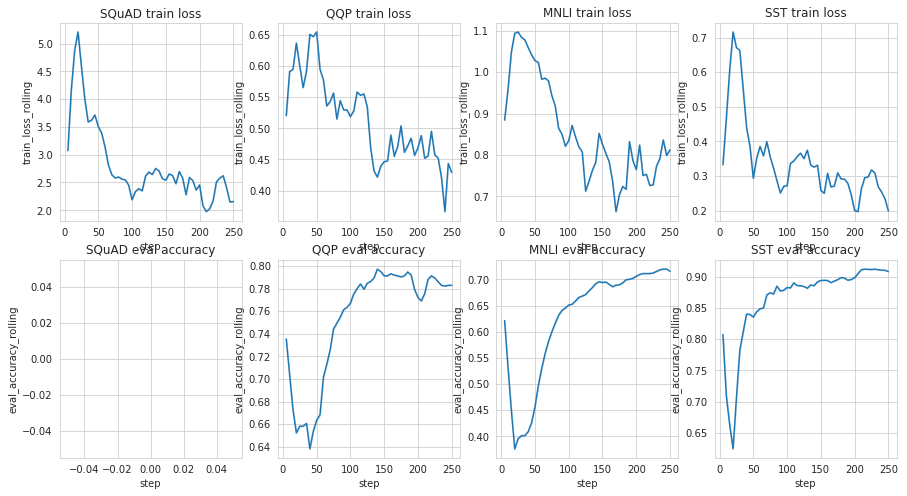

In [380]:
models = [m for m in bert_models if m is not None]
f, axs = plt.subplots(2, len(models), figsize=(15, 8))

for model, ax in zip(models, axs[0]):
    model_data = pd.melt(df[df.model == model], id_vars=["step"], value_vars=["train_loss"])
    sns.lineplot(data=model_data.assign(train_loss_rolling=model_data.value.rolling(4).mean()),
                 x="step", y="train_loss_rolling", ax=ax)
    ax.set_title("%s train loss" % model)
    
for model, ax in zip(models, axs[1]):
    model_data = pd.melt(df[df.model == model], id_vars=["step"], value_vars=["eval_accuracy"])
    sns.lineplot(data=model_data.assign(eval_accuracy_rolling=model_data.value.rolling(4).mean()),
                 x="step", y="eval_accuracy_rolling", ax=ax)
    ax.set_title("%s eval accuracy" % model)

MRPC and RTE are definitely overfitting — let's exclude some of the later training steps.

In [325]:
df = df.drop(index=df[(df.model == "MRPC") & (df.step > 750)].index)
df = df.drop(index=df[(df.model == "RTE") & (df.step > 1000)].index)
df.describe()

,step,decoding_mean,decoding_std,first_train_loss,first_train_loss_norm,train_loss,train_loss_norm,total_global_norms,eval_loss,eval_accuracy,train_loss_delta,train_loss_norm_delta,eval_accuracy_norm,decoding_mean_delta
count,1600.000000,1600.000000,1600.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1600.000000
mean,127.500000,108.867571,24.297114,0.846178,0.363913,0.570760,0.237706,153.005016,0.543838,0.747428,-0.275418,-0.126206,0.795052,12.608973
std,72.176907,32.358649,6.848891,0.158165,0.017131,0.256879,0.079530,95.648708,0.237395,0.130952,0.180117,0.090292,0.265876,15.731369
min,5.000000,46.915344,12.715105,0.697641,0.348820,0.119879,0.059940,3.879289,0.235914,0.342500,-0.655841,-0.327921,0.000000,-4.457672
25%,65.000000,77.224868,19.130700,0.697641,0.348820,0.375162,0.186498,64.950856,0.324944,0.686250,-0.400559,-0.185534,0.779605,0.000000
50%,127.500000,115.431217,23.249480,0.775721,0.355057,0.541429,0.242785,153.162016,0.465438,0.772500,-0.264678,-0.114700,0.911043,3.990741
75%,190.000000,133.382275,29.632157,1.065172,0.387860,0.767172,0.293264,230.163339,0.707708,0.871250,-0.146359,-0.059788,0.958333,24.910714
max,250.000000,167.759259,39.899241,1.065172,0.387860,1.119146,0.387860,350.472056,1.100075,0.913750,0.075408,0.037704,1.000000,63.386243


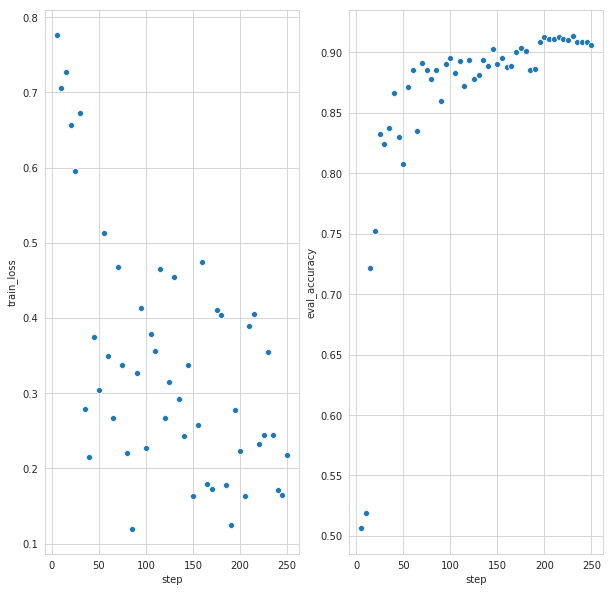

In [326]:
f, axs = plt.subplots(1, 2, figsize=(10, 10))
sns.scatterplot(data=df[df.model == "SST"], x="step", y="train_loss", ax=axs[0])
sns.scatterplot(data=df[df.model == "SST"], x="step", y="eval_accuracy", ax=axs[1])

SST also converges early (around 4000 iters). We'll drop the remaining iterations.

In [327]:
df = df.drop(index=df[(df.model == "SST") & (df.step > 4000)].index)
df.describe()

,step,decoding_mean,decoding_std,first_train_loss,first_train_loss_norm,train_loss,train_loss_norm,total_global_norms,eval_loss,eval_accuracy,train_loss_delta,train_loss_norm_delta,eval_accuracy_norm,decoding_mean_delta
count,1600.000000,1600.000000,1600.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1600.000000
mean,127.500000,108.867571,24.297114,0.846178,0.363913,0.570760,0.237706,153.005016,0.543838,0.747428,-0.275418,-0.126206,0.795052,12.608973
std,72.176907,32.358649,6.848891,0.158165,0.017131,0.256879,0.079530,95.648708,0.237395,0.130952,0.180117,0.090292,0.265876,15.731369
min,5.000000,46.915344,12.715105,0.697641,0.348820,0.119879,0.059940,3.879289,0.235914,0.342500,-0.655841,-0.327921,0.000000,-4.457672
25%,65.000000,77.224868,19.130700,0.697641,0.348820,0.375162,0.186498,64.950856,0.324944,0.686250,-0.400559,-0.185534,0.779605,0.000000
50%,127.500000,115.431217,23.249480,0.775721,0.355057,0.541429,0.242785,153.162016,0.465438,0.772500,-0.264678,-0.114700,0.911043,3.990741
75%,190.000000,133.382275,29.632157,1.065172,0.387860,0.767172,0.293264,230.163339,0.707708,0.871250,-0.146359,-0.059788,0.958333,24.910714
max,250.000000,167.759259,39.899241,1.065172,0.387860,1.119146,0.387860,350.472056,1.100075,0.913750,0.075408,0.037704,1.000000,63.386243


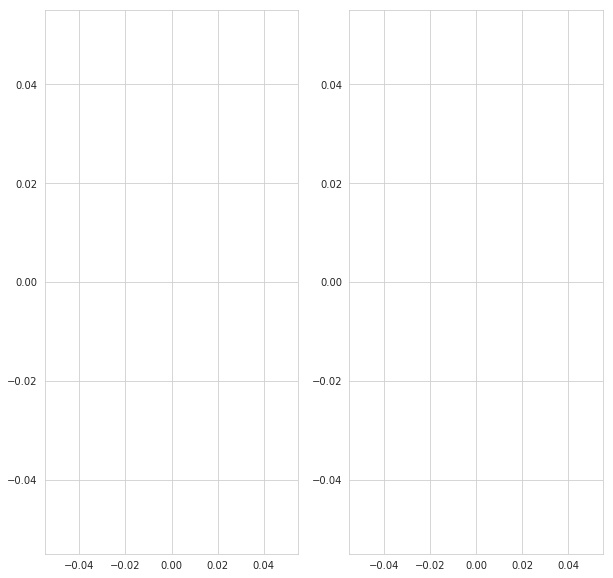

In [328]:
f, axs = plt.subplots(1, 2, figsize=(10, 10))
sns.scatterplot(data=df[df.model == "CoLA"], x="step", y="train_loss", ax=axs[0])
sns.scatterplot(data=df[df.model == "CoLA"], x="step", y="eval_accuracy", ax=axs[1])

CoLA is also overfitting — we reach near-zero training loss by around iter 2000. Drop.

In [329]:
df = df.drop(index=df[(df.model == "CoLA") & (df.step > 2000)].index)
df.describe()

,step,decoding_mean,decoding_std,first_train_loss,first_train_loss_norm,train_loss,train_loss_norm,total_global_norms,eval_loss,eval_accuracy,train_loss_delta,train_loss_norm_delta,eval_accuracy_norm,decoding_mean_delta
count,1600.000000,1600.000000,1600.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1600.000000
mean,127.500000,108.867571,24.297114,0.846178,0.363913,0.570760,0.237706,153.005016,0.543838,0.747428,-0.275418,-0.126206,0.795052,12.608973
std,72.176907,32.358649,6.848891,0.158165,0.017131,0.256879,0.079530,95.648708,0.237395,0.130952,0.180117,0.090292,0.265876,15.731369
min,5.000000,46.915344,12.715105,0.697641,0.348820,0.119879,0.059940,3.879289,0.235914,0.342500,-0.655841,-0.327921,0.000000,-4.457672
25%,65.000000,77.224868,19.130700,0.697641,0.348820,0.375162,0.186498,64.950856,0.324944,0.686250,-0.400559,-0.185534,0.779605,0.000000
50%,127.500000,115.431217,23.249480,0.775721,0.355057,0.541429,0.242785,153.162016,0.465438,0.772500,-0.264678,-0.114700,0.911043,3.990741
75%,190.000000,133.382275,29.632157,1.065172,0.387860,0.767172,0.293264,230.163339,0.707708,0.871250,-0.146359,-0.059788,0.958333,24.910714
max,250.000000,167.759259,39.899241,1.065172,0.387860,1.119146,0.387860,350.472056,1.100075,0.913750,0.075408,0.037704,1.000000,63.386243


In [330]:
df = df.drop(index=df[(df.model == "QQP") & (df.step > 4000)].index)
df.describe()

,step,decoding_mean,decoding_std,first_train_loss,first_train_loss_norm,train_loss,train_loss_norm,total_global_norms,eval_loss,eval_accuracy,train_loss_delta,train_loss_norm_delta,eval_accuracy_norm,decoding_mean_delta
count,1600.000000,1600.000000,1600.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1600.000000
mean,127.500000,108.867571,24.297114,0.846178,0.363913,0.570760,0.237706,153.005016,0.543838,0.747428,-0.275418,-0.126206,0.795052,12.608973
std,72.176907,32.358649,6.848891,0.158165,0.017131,0.256879,0.079530,95.648708,0.237395,0.130952,0.180117,0.090292,0.265876,15.731369
min,5.000000,46.915344,12.715105,0.697641,0.348820,0.119879,0.059940,3.879289,0.235914,0.342500,-0.655841,-0.327921,0.000000,-4.457672
25%,65.000000,77.224868,19.130700,0.697641,0.348820,0.375162,0.186498,64.950856,0.324944,0.686250,-0.400559,-0.185534,0.779605,0.000000
50%,127.500000,115.431217,23.249480,0.775721,0.355057,0.541429,0.242785,153.162016,0.465438,0.772500,-0.264678,-0.114700,0.911043,3.990741
75%,190.000000,133.382275,29.632157,1.065172,0.387860,0.767172,0.293264,230.163339,0.707708,0.871250,-0.146359,-0.059788,0.958333,24.910714
max,250.000000,167.759259,39.899241,1.065172,0.387860,1.119146,0.387860,350.472056,1.100075,0.913750,0.075408,0.037704,1.000000,63.386243


## Decoding analyses

In [331]:
MAR_DELTA_LABEL = "$\Delta$(MAR$_j$)"

### Step analysis

Text(0.5,1,'Decoding performance vs. total number of fine-tuning steps')

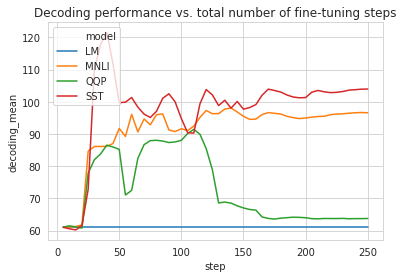

In [332]:
sns.lineplot(data=df[df.subject == "M02"], y="decoding_mean", x="step", hue="model")
plt.title("Decoding performance vs. total number of fine-tuning steps")

Text(0,0.5,'$\\Delta$(MAR$_j$)')

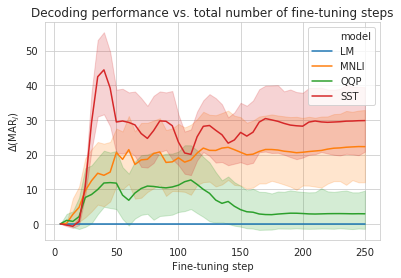

In [333]:
sns.lineplot(data=df.reset_index(), y="decoding_mean_delta", x="step", hue="model")
plt.title("Decoding performance vs. total number of fine-tuning steps")
plt.xlabel("Fine-tuning step")
plt.ylabel(MAR_DELTA_LABEL)

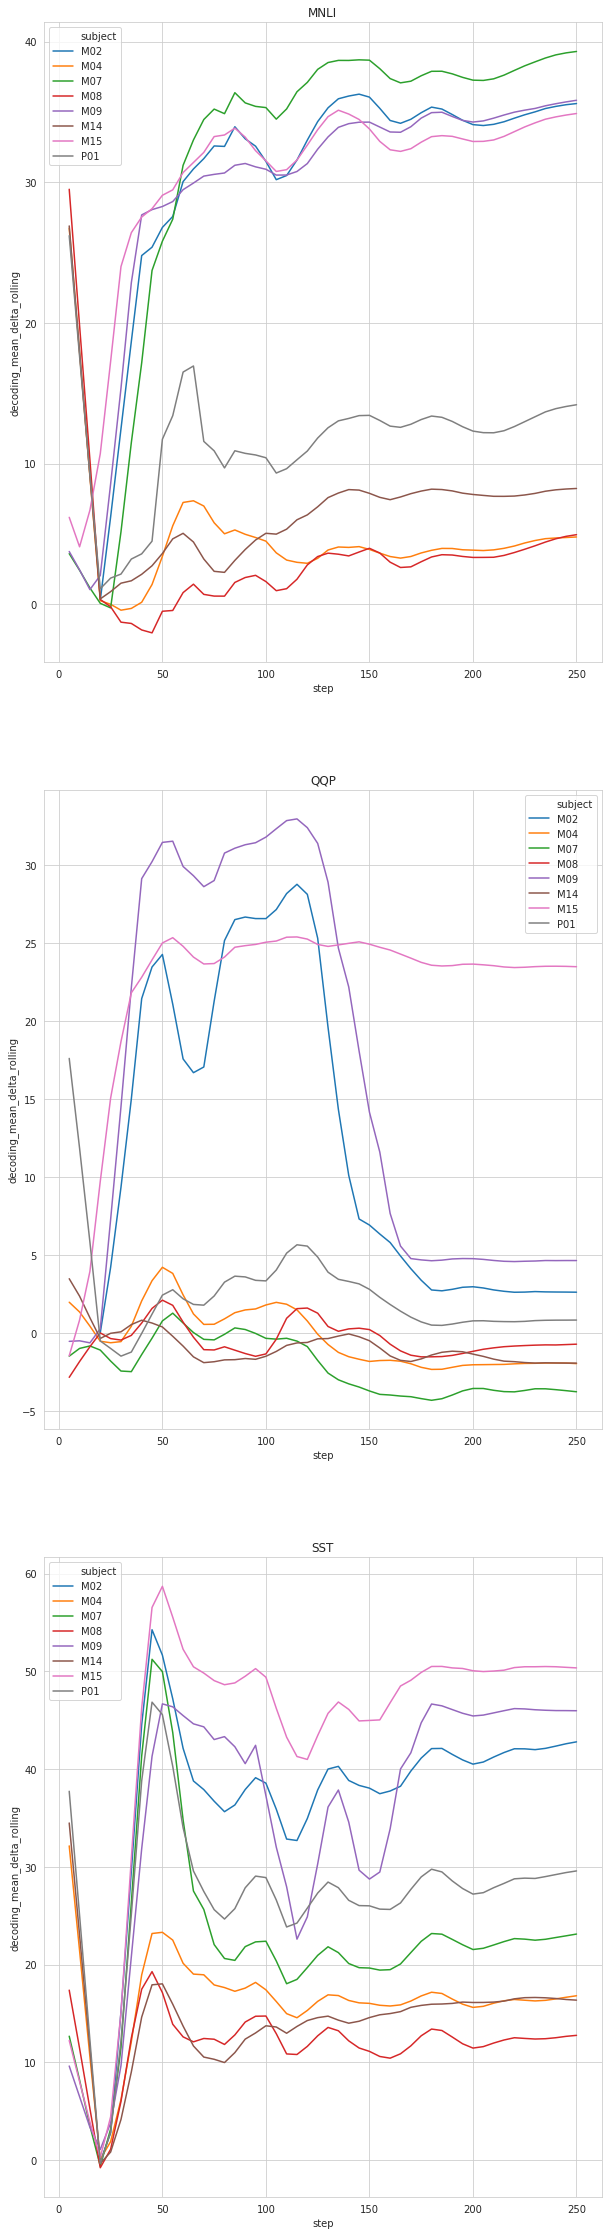

In [334]:
fig, axs = plt.subplots(len(df.model.unique()) - 1, 1, figsize=(10, len(df.model.unique()) * 10))
for ax, (model, data) in zip(axs, df[df.model != "LM"].groupby("model", as_index=False)):
    sns.lineplot(data=data.assign(decoding_mean_delta_rolling=data.decoding_mean_delta.rolling(4).mean()), y="decoding_mean_delta_rolling", x="step", hue="subject", ax=ax)
    ax.set_title(model)

Text(0.5,1,'Decoding performance vs. total global gradient norm')

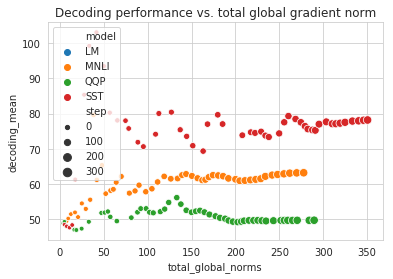

In [335]:
sns.scatterplot(data=df[df.subject == "P01"], y="decoding_mean", x="total_global_norms", hue="model", size="step")
plt.title("Decoding performance vs. total global gradient norm")

### Gradient norm analysis

Text(0,0.5,'$\\Delta$(MAR$_j$)')

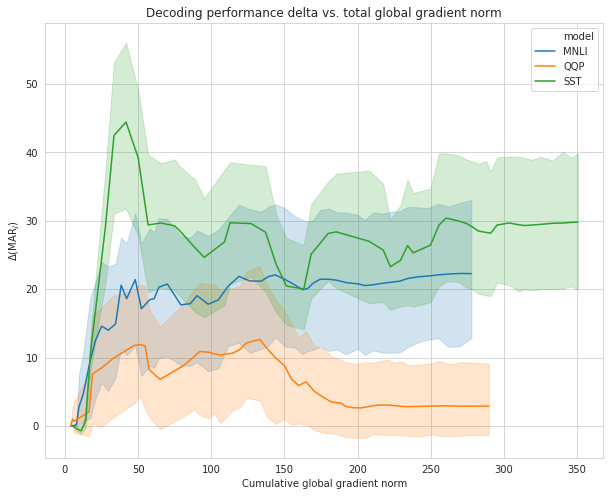

In [336]:
f, ax = plt.subplots(figsize=(10, 8))
sns.lineplot(data=df[df.model != "LM"], y="decoding_mean_delta", x="total_global_norms", hue="model", ax=ax)
ax.set_title("Decoding performance delta vs. total global gradient norm")
ax.set_xlabel("Cumulative global gradient norm")
ax.set_ylabel(MAR_DELTA_LABEL)

Text(24.5594,0.5,'$\\Delta$(MAR$_j$)')

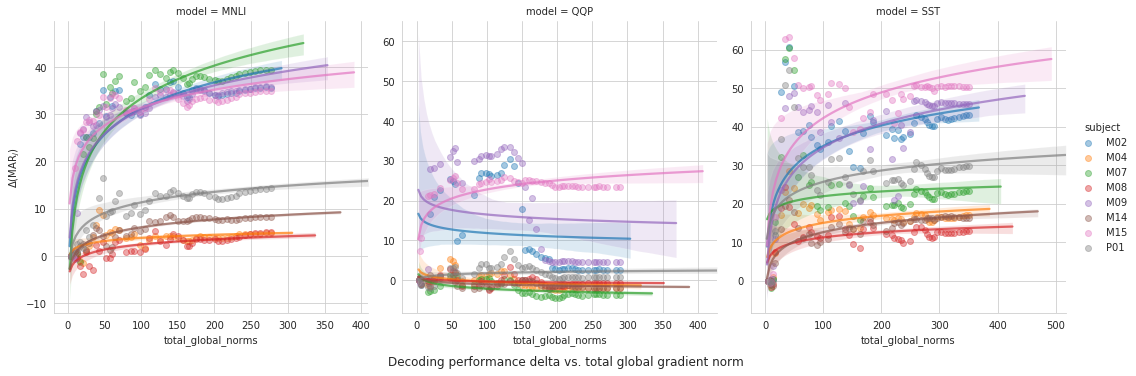

In [337]:
g = sns.lmplot(data=df[df.model != "LM"], y="decoding_mean_delta", x="total_global_norms", col="model", hue="subject",
               logx=True, sharex=False, sharey=False, scatter_kws={"alpha": 0.4}, line_kws={"alpha": 0.7})
plt.suptitle("Decoding performance delta vs. total global gradient norm", y=0)
g.axes.ravel()[0].set_ylabel(MAR_DELTA_LABEL)

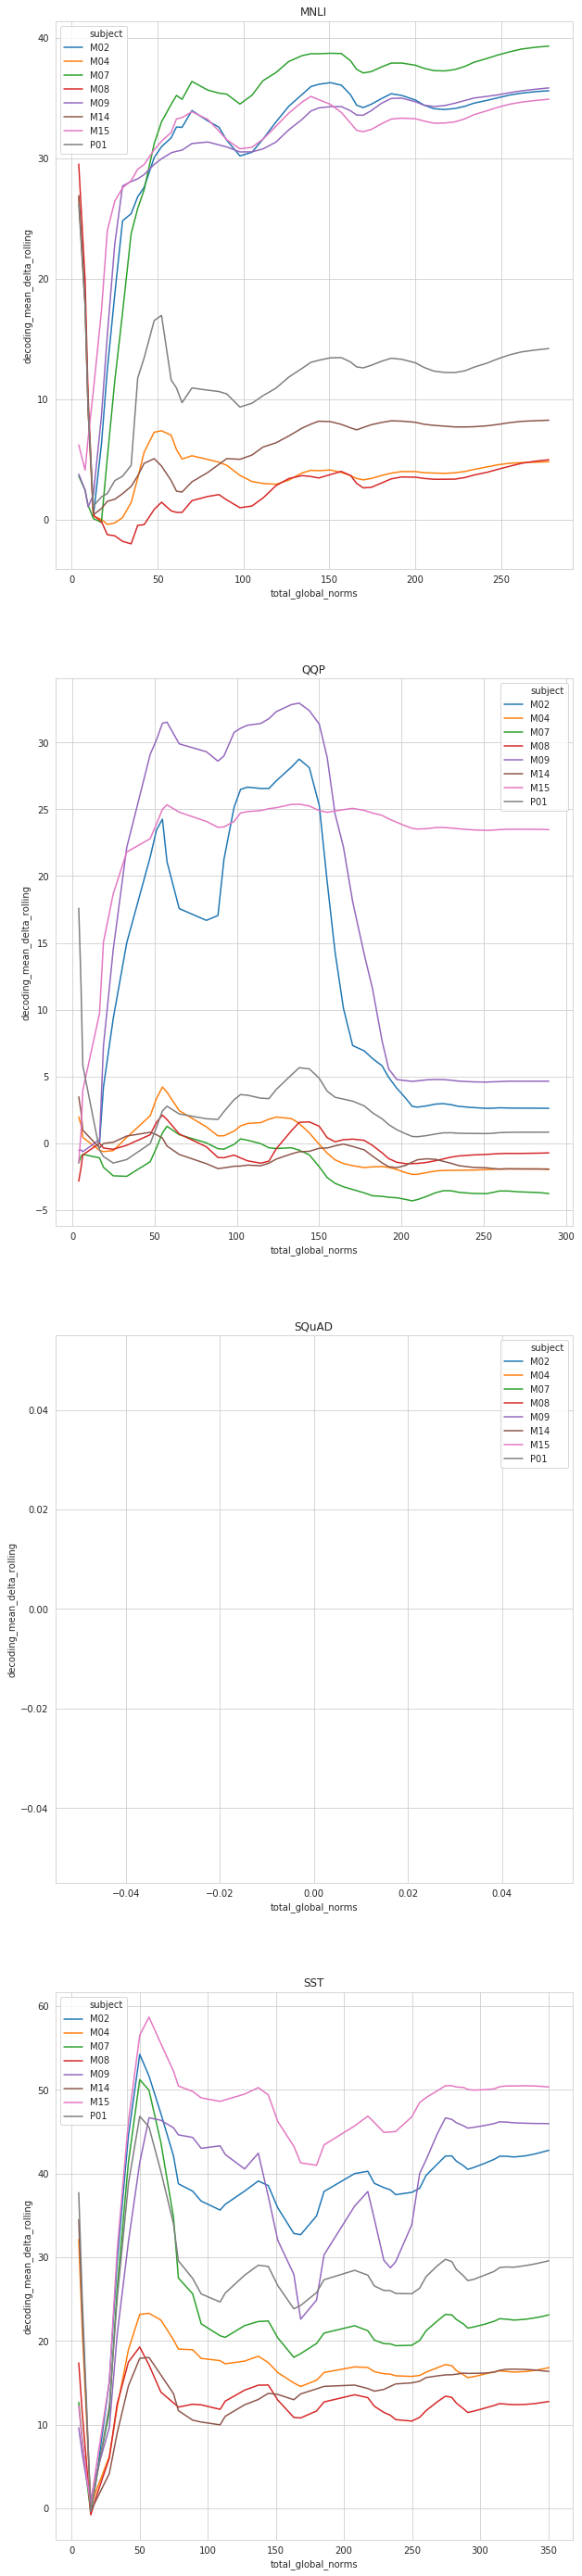

In [381]:
fig, axs = plt.subplots(len(df.model.unique()) - 1, 1, figsize=(10, len(df.model.unique()) * 10))
for ax, (model, data) in zip(axs, df[df.model != "LM"].groupby("model", as_index=False)):
    sns.lineplot(data=data.assign(decoding_mean_delta_rolling=data.decoding_mean_delta.rolling(4).mean()), y="decoding_mean_delta_rolling", x="total_global_norms", hue="subject", ax=ax)
    ax.set_title(model)

### Eval accuracy analysis

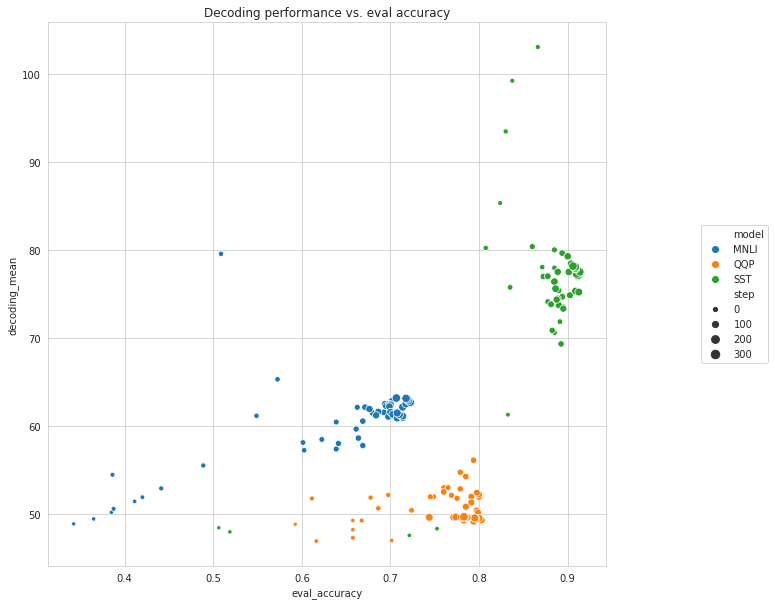

In [338]:
# NB: not directly comparable since the classification tasks have different output spaces
plt.subplots(figsize=(10, 10))
sns.scatterplot(data=df[(df.model != "LM") & (df.subject == "P01")], y="decoding_mean", x="eval_accuracy", hue="model", size="step")
plt.title("Decoding performance vs. eval accuracy")
plt.legend(loc="right", bbox_to_anchor=(1.3, 0.5))

(-10, 60)

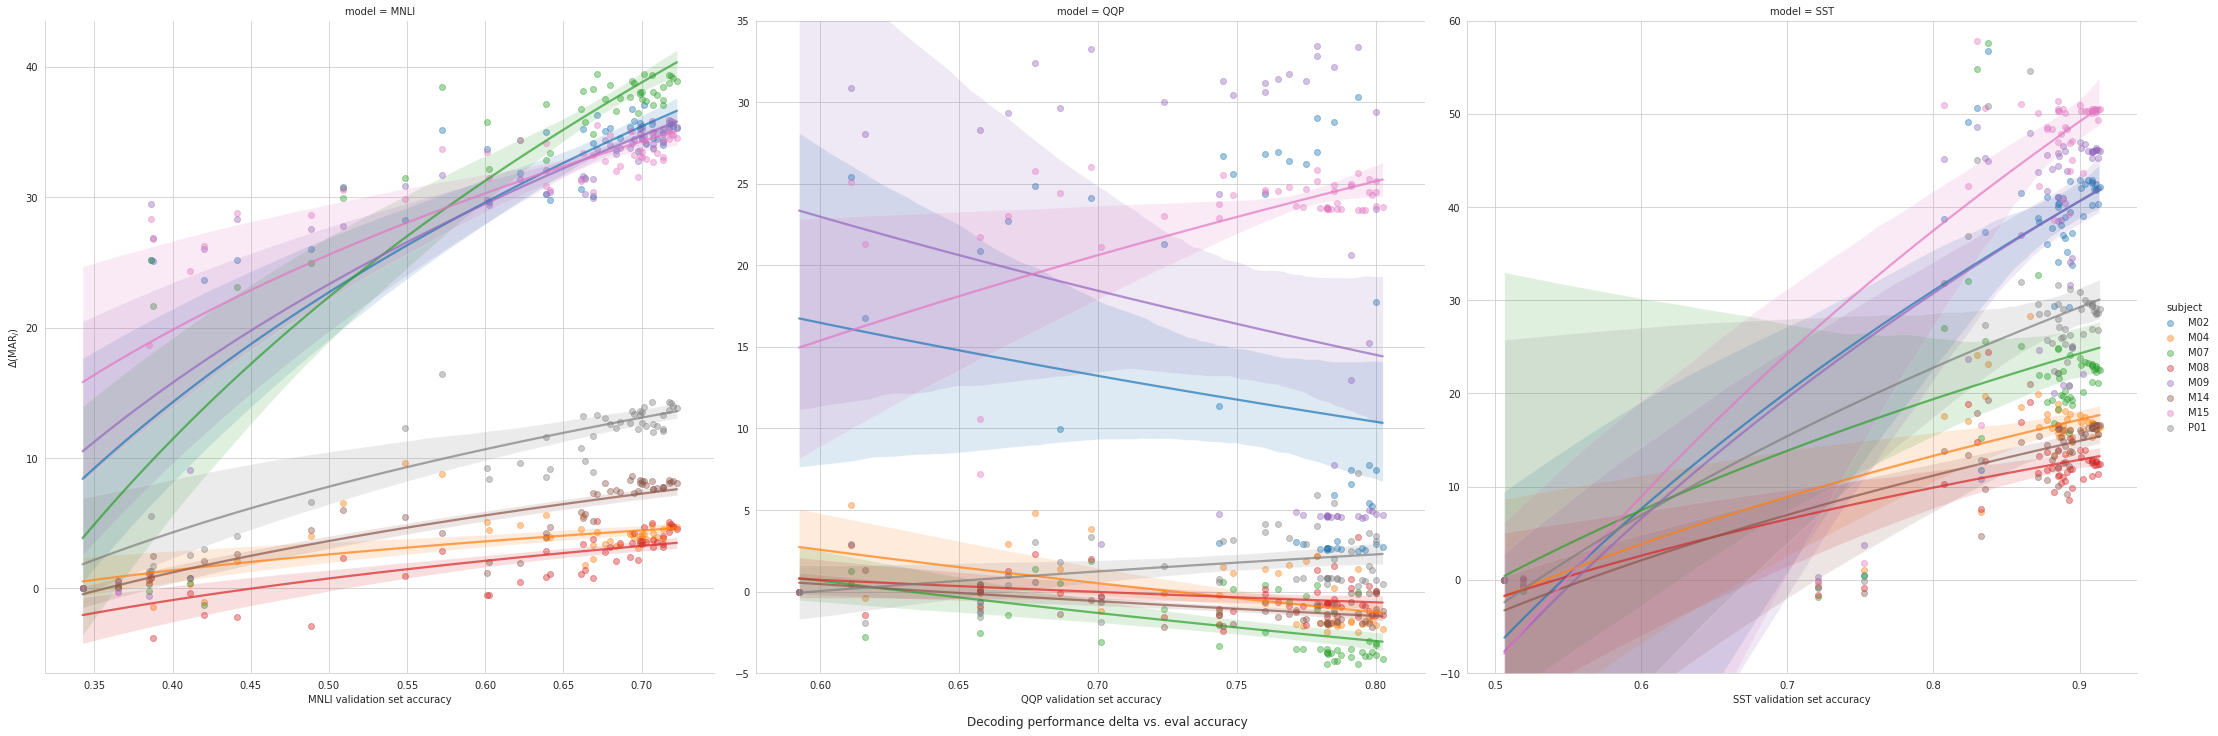

In [339]:
g = sns.lmplot(data=df[df.model != "LM"], y="decoding_mean_delta", x="eval_accuracy", col="model", hue="subject", 
               sharex=False, sharey=False, truncate=True, logx=True, scatter_kws={"alpha": 0.4}, line_kws={"alpha": 0.7}, height=10)
plt.suptitle("Decoding performance delta vs. eval accuracy", y=0.0)

axs = g.axes.ravel()
axs[0].set_ylabel(MAR_DELTA_LABEL)
for ax in axs:
    model_name = re.match(r"^model = (.+)$", ax.get_title())
    ax.set_xlabel("%s validation set accuracy" % model_name.group(1))
axs[1].set_ylim((-5, 35)) # QQP
axs[-1].set_ylim((-10, 60)) # SNLI

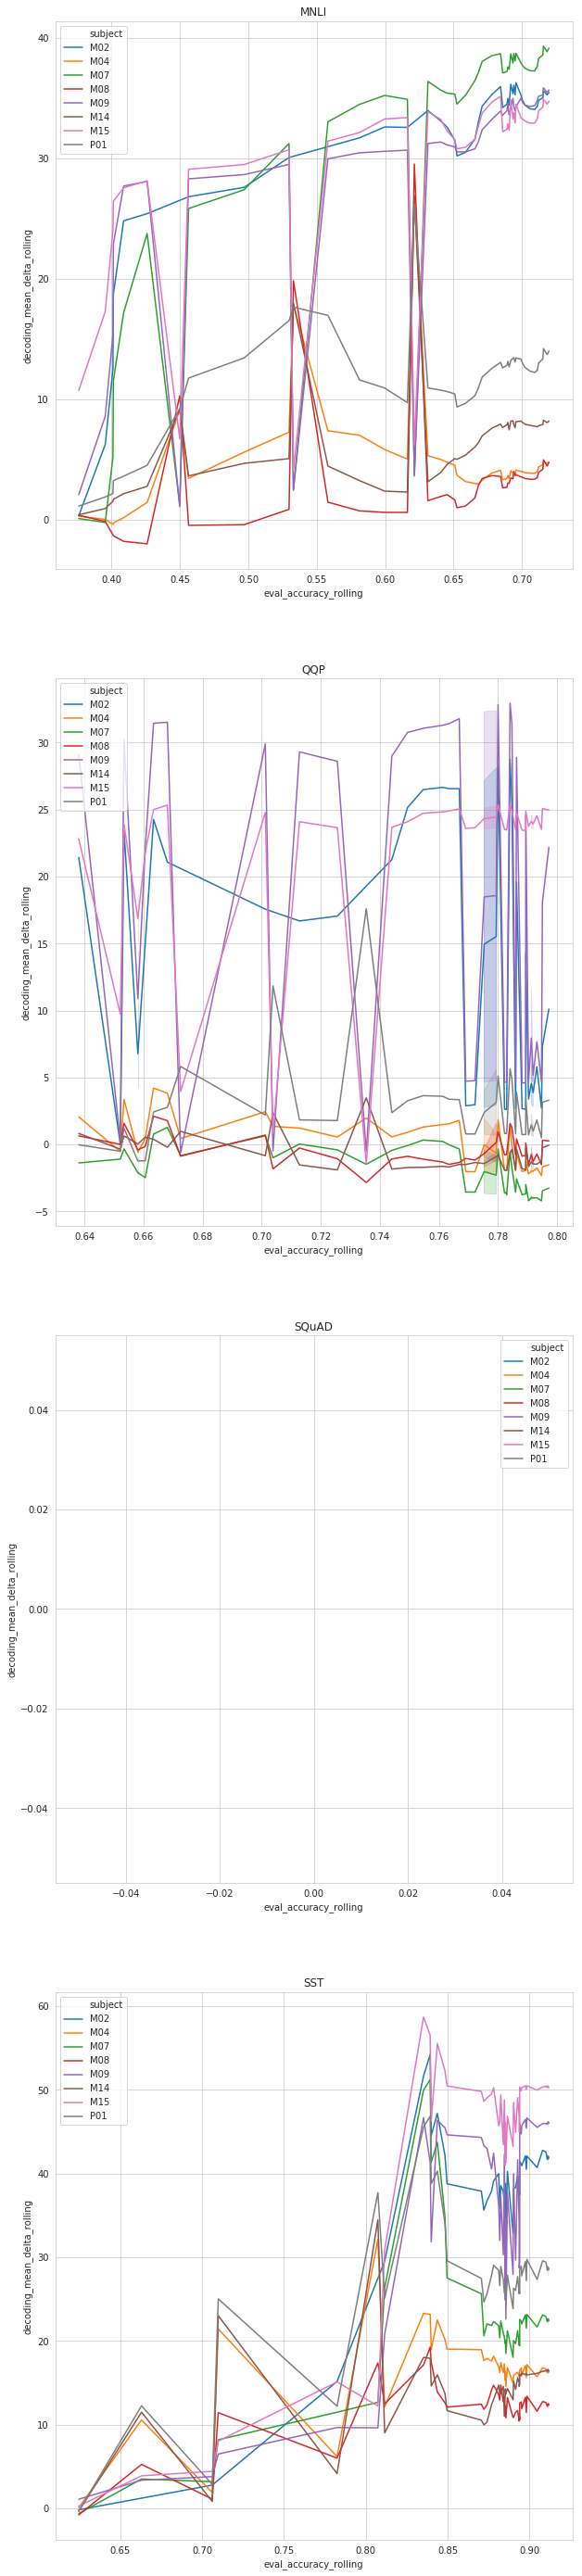

In [384]:
fig, axs = plt.subplots(len(df.model.unique()) - 1, 1, figsize=(10, len(df.model.unique()) * 10))
for ax, (model, data) in zip(axs, df[df.model != "LM"].groupby("model", as_index=False)):
    sns.lineplot(data=data.assign(decoding_mean_delta_rolling=data.decoding_mean_delta.rolling(4).mean(),
                                  eval_accuracy_rolling=data.eval_accuracy.rolling(4).mean()),
                 y="decoding_mean_delta_rolling", x="eval_accuracy_rolling", hue="subject", ax=ax)
    ax.set_title(model)

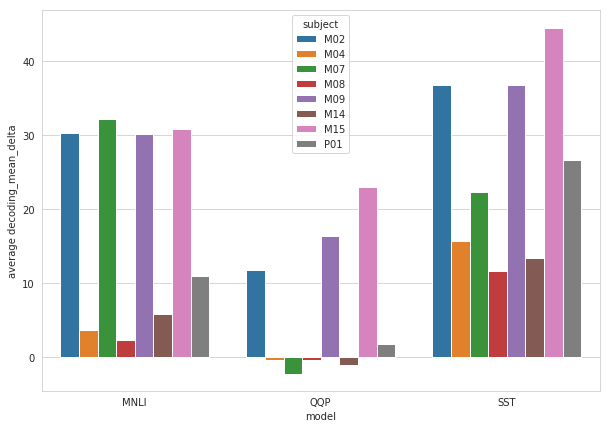

In [340]:
f, ax = plt.subplots(figsize=(10, 7))
dff = df[df.model != "LM"].groupby("model").apply(lambda xs: xs.groupby("subject").decoding_mean_delta.mean()).reset_index().melt(id_vars=["model"], value_name="average decoding_mean_delta")
sns.barplot(data=dff, x="model", hue="subject", y="average decoding_mean_delta", ax=ax)

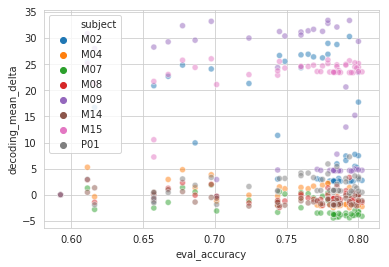

In [341]:
sns.scatterplot(data=df[df.model == "QQP"], x="eval_accuracy", y="decoding_mean_delta", hue="subject", alpha=0.5)

Text(0.5,0,'Model validation set accuracy')

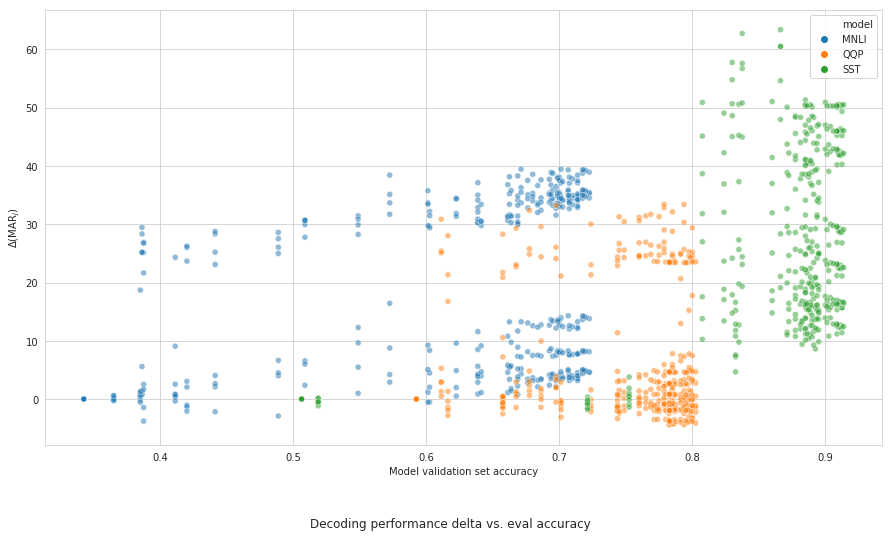

In [342]:
f, ax = plt.subplots(figsize=(15, 8))
sns.scatterplot(data=df[(df.model != "LM")], y="decoding_mean_delta", x="eval_accuracy", hue="model", ax=ax, alpha=0.5)
plt.suptitle("Decoding performance delta vs. eval accuracy", y=0.0)
ax.set_ylabel(MAR_DELTA_LABEL)
ax.set_xlabel("Model validation set accuracy")

Text(0.5,0,'Decoding performance delta vs. normalized eval accuracy')

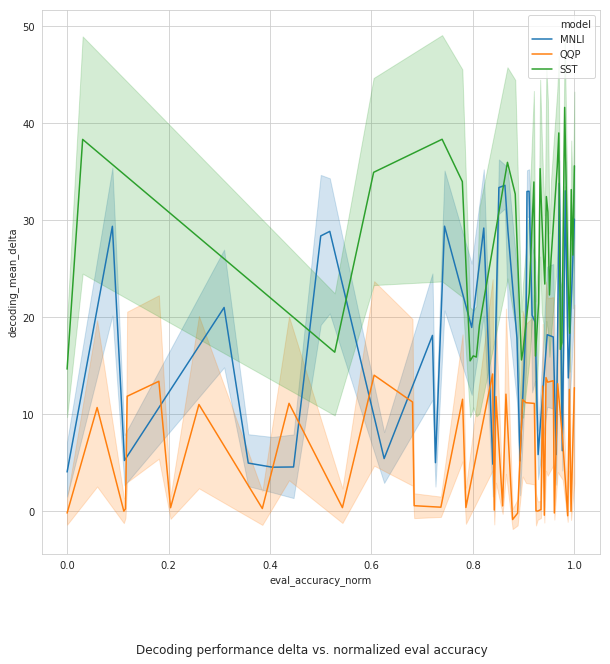

In [343]:
f, ax = plt.subplots(figsize=(10,10))
sns.lineplot(data=df[(df.model != "LM")], y="decoding_mean_delta", x="eval_accuracy_norm", hue="model", ax=ax)
plt.suptitle("Decoding performance delta vs. normalized eval accuracy", y=0.0)

## Regression analyses

In [344]:
from statsmodels.tools import tools

ols_results = []
for (model, subject), model_data in df[df.model != "LM"].groupby(["model", "subject"]):
    X = model_data.eval_accuracy * 100
    # Add bias term.
    #X = np.concatenate([X[:, np.newaxis], np.ones((X.shape[0], 1))], axis=1)
    X = tools.add_constant(X)
    #X -= X.mean()
    #X /= X.std()
    y = model_data.decoding_mean_delta
    #y -= y.mean()
    #y /= y.std()
    
    reg = smf.OLS(y, X).fit()
    ols_results.append((model, subject, reg.params.eval_accuracy, reg.params.const, reg.rsquared))
    
#     print(model, subject)
#     print(reg.summary())

ols_results = pd.DataFrame(ols_results, columns=["model", "subject", "slope", "intercept", "r2"])

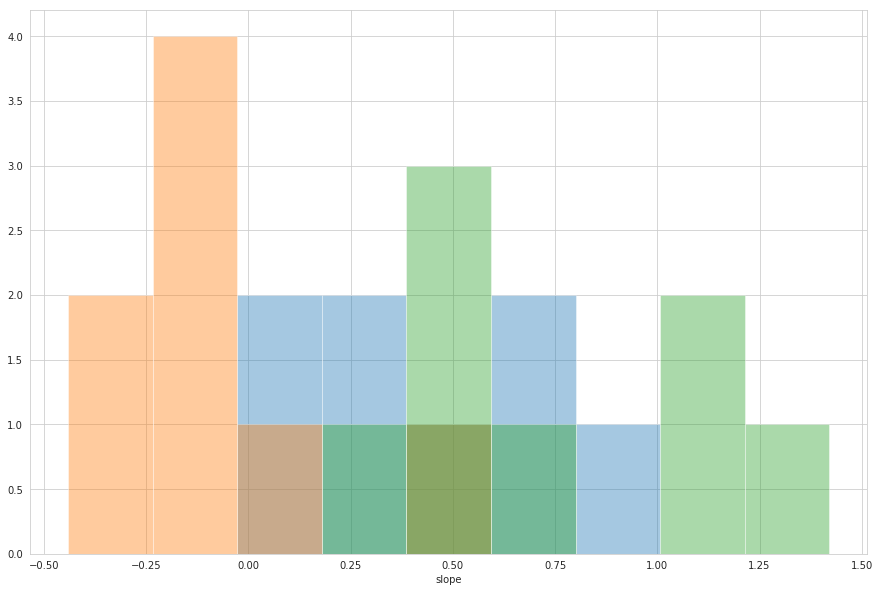

In [345]:
fig, ax = plt.subplots(figsize=(15, 10))
bins = np.linspace(ols_results.slope.min(), ols_results.slope.max(), 10)
for model, ols_results_m in ols_results.groupby("model"):
    sns.distplot(ols_results_m.slope, bins=bins, ax=ax, kde=False)

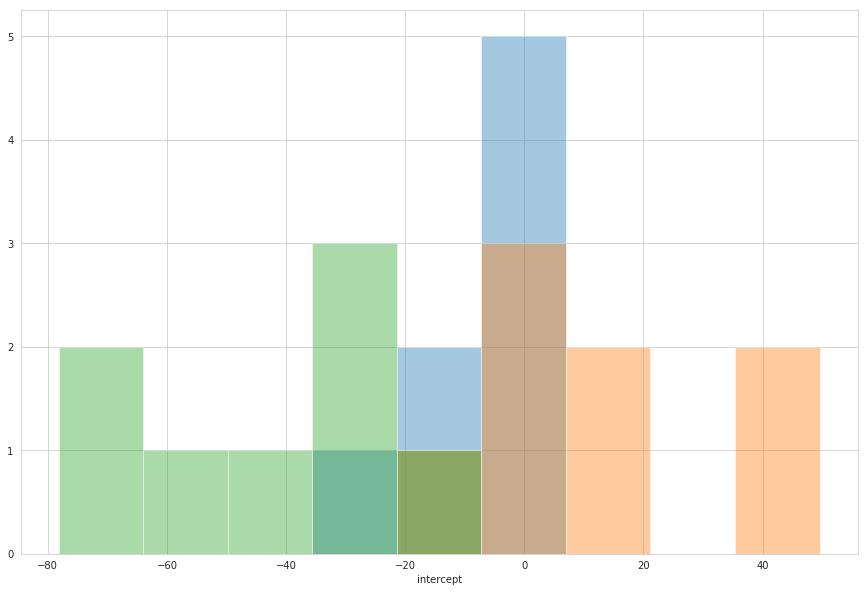

In [346]:
fig, ax = plt.subplots(figsize=(15, 10))
bins = np.linspace(ols_results.intercept.min(), ols_results.intercept.max(), 10)
for model, ols_results_m in ols_results.groupby("model"):
    sns.distplot(ols_results_m.intercept, bins=bins, ax=ax, kde=False)

Text(0,0.5,'Estimated $\\Delta$(MAR$_j$) / $\\Delta$(Eval accuracy)')

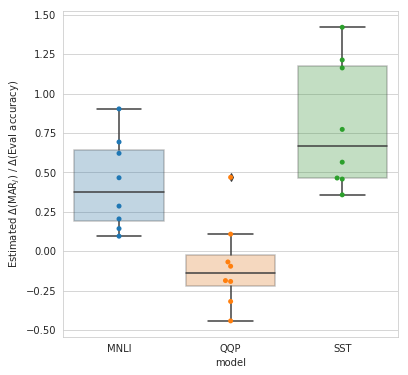

In [347]:
f, ax = plt.subplots(figsize=(6, 6))

sns.swarmplot(data=ols_results, x="model", y="slope", ax=ax)
sns.boxplot(data=ols_results, x="model", y="slope", ax=ax, boxprops=dict(alpha=0.3))
ax.set_ylabel("Estimated %s / $\Delta$(Eval accuracy)" % MAR_DELTA_LABEL)

Text(0,0.5,'Estimated intercept')

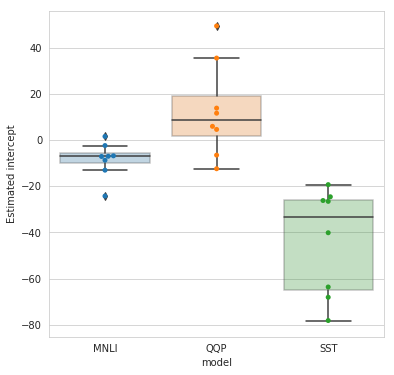

In [348]:
f, ax = plt.subplots(figsize=(6, 6))

sns.swarmplot(data=ols_results, x="model", y="intercept", ax=ax)
sns.boxplot(data=ols_results, x="model", y="intercept", ax=ax, boxprops=dict(alpha=0.3))
ax.set_ylabel("Estimated intercept")

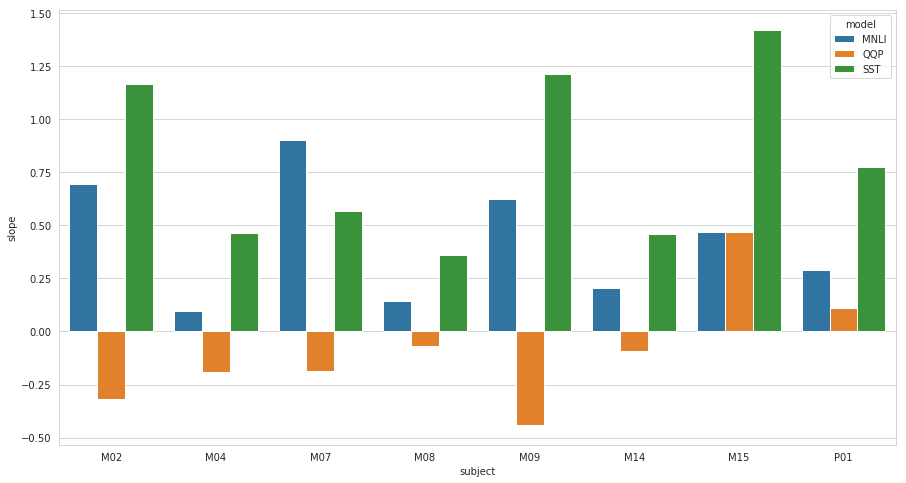

In [349]:
f, ax = plt.subplots(figsize=(15, 8))
sns.barplot(data=ols_results, x="subject", hue="model", y="slope", ax=ax)

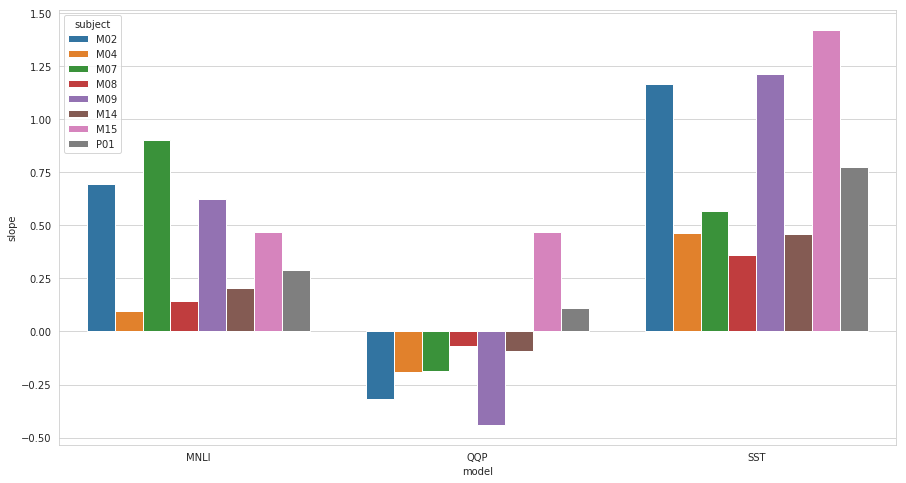

In [350]:
f, ax = plt.subplots(figsize=(15, 8))
sns.barplot(data=ols_results, x="model", hue="subject", y="slope", ax=ax)

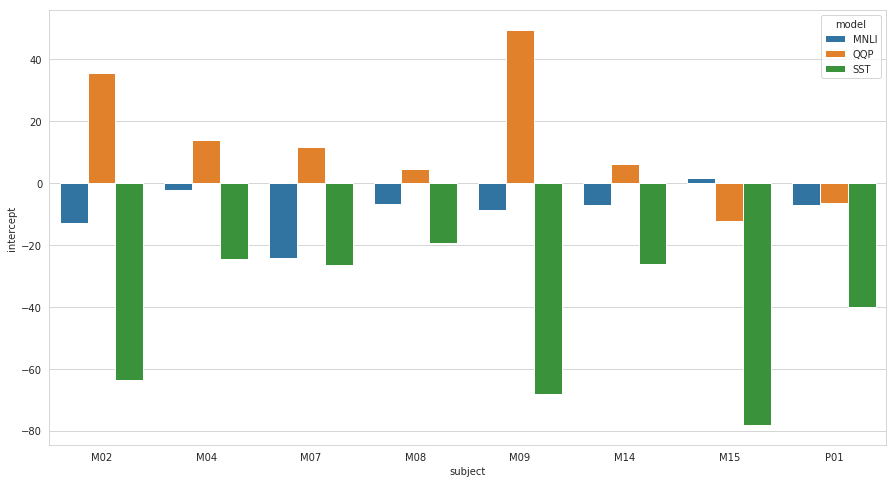

In [351]:
f, ax = plt.subplots(figsize=(15, 8))
sns.barplot(data=ols_results, x="subject", hue="model", y="intercept", ax=ax)

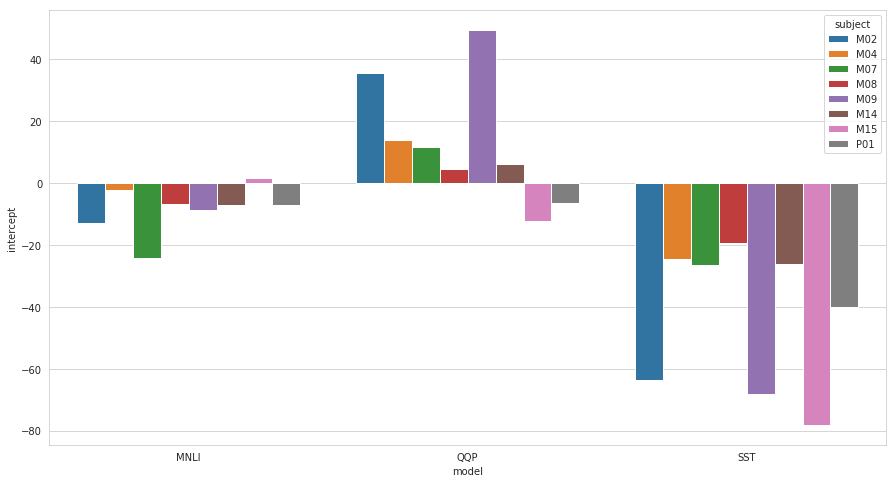

In [352]:
f, ax = plt.subplots(figsize=(15, 8))
sns.barplot(data=ols_results, x="model", hue="subject", y="intercept", ax=ax)

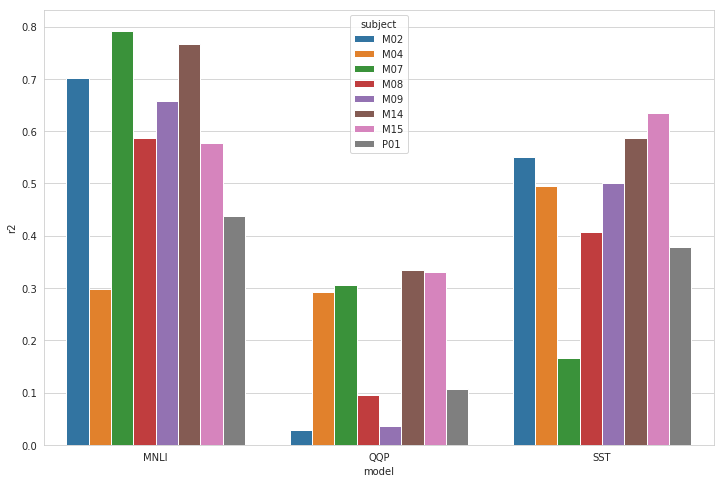

In [353]:
f, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=ols_results, x="model", y="r2", hue="subject", ax=ax)

In [354]:
ols_results.sort_values("r2")

,model,subject,slope,intercept,r2
8,QQP,M02,-0.317284,35.636898,0.027514
12,QQP,M09,-0.440667,49.559953,0.036213
11,QQP,M08,-0.067102,4.695193,0.095587
15,QQP,P01,0.109299,-6.450112,0.105984
18,SST,M07,0.565324,-26.500294,0.166609
9,QQP,M04,-0.190659,13.936154,0.291430
1,MNLI,M04,0.096252,-2.302548,0.297925
10,QQP,M07,-0.185200,11.729568,0.304880
14,QQP,M15,0.469436,-12.352641,0.330112
13,QQP,M14,-0.094223,6.029524,0.335320


In [355]:
%load_ext rpy2.ipython
%R require(brms)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array([1], dtype=int32)

In [356]:
regression_data = df[df.model.notnull()]
regression_data.to_csv("regression_data.csv")

In [357]:
%R summary(brm("decoding_mean ~ eval_accuracy + (1 + eval_accuracy | subject) + (1 + eval_accuracy | model)",
               data=read.csv("regression_data.csv"), iter=2000, chains=10, cores=10))

IndentationError: unexpected indent (<ipython-input-357-d7ec5954b5c7>, line 2)

R results from the above regression, run from the command line (19 Feb 2019 12:46):

```
> ranef(mylm)
$model
, , Intercept

      Estimate Est.Error      Q2.5     Q97.5
MNLI  16.75141  22.41457 -28.67321 62.633228
QQP   33.96295  22.71539 -10.84474 80.443706
SST  -51.11941  22.68847 -97.77289 -5.678948

, , eval_accuracy

      Estimate Est.Error        Q2.5      Q97.5
MNLI -17.34233  32.23074  -82.818005  46.545622
QQP  -60.07987  32.50367 -126.434392   4.141062
SST   73.80767  32.45963    8.068293 139.260863


$subject
, , Intercept

     Estimate Est.Error        Q2.5      Q97.5
M02 -52.60407  19.08174  -89.177671 -14.155082
M04  60.89416  19.02727   23.720952  99.224670
M07 -28.94065  19.08834  -66.611534   8.715856
M08  35.14006  19.06391   -1.525497  73.038507
M09  57.39263  19.05641   20.876435  95.498854
M14  46.39296  19.10505    9.697139  84.118757
M15 -31.00785  19.16315  -68.451523   7.205317
P01 -92.88771  19.02479 -129.951903 -54.686867

, , eval_accuracy

     Estimate Est.Error        Q2.5     Q97.5
M02  27.99022  13.44256   0.9550976  53.68828
M04 -45.23083  13.34530 -72.4967273 -19.22681
M07  16.20350  13.40520 -10.1863048  43.10497
M08 -29.82243  13.34506 -56.5382954  -3.72094
M09 -41.79735  13.42123 -68.6505984 -15.72548
M14 -10.06899  13.44356 -37.0225402  15.87794
M15  36.78132  13.59707   9.4990463  63.47709
P01  48.49375  13.40848  21.8274816  74.81344

> print(summary(mylm))
 Family: gaussian
  Links: mu = identity; sigma = identity
Formula: decoding_mean ~ eval_accuracy + (1 + eval_accuracy | subject) + (1 + eval_accuracy | model)
   Data: read.csv("regression_data.csv") (Number of observations: 4480)
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Group-Level Effects:
~model (Number of levels: 3)
                             Estimate Est.Error l-95% CI u-95% CI Eff.Sample
sd(Intercept)                   40.63     15.39    20.68    79.10       2248
sd(eval_accuracy)               56.98     18.27    31.11   101.90       2454
cor(Intercept,eval_accuracy)    -0.70      0.29    -0.99     0.07       1846
                             Rhat
sd(Intercept)                1.00
sd(eval_accuracy)            1.00
cor(Intercept,eval_accuracy) 1.00

~subject (Number of levels: 8)
                             Estimate Est.Error l-95% CI u-95% CI Eff.Sample
sd(Intercept)                   54.54     12.39    35.53    83.32       1440
sd(eval_accuracy)               35.29      8.42    22.94    55.87       1577
cor(Intercept,eval_accuracy)    -0.85      0.12    -0.97    -0.54       2211
                             Rhat
sd(Intercept)                1.00
sd(eval_accuracy)            1.00
cor(Intercept,eval_accuracy) 1.00

Population-Level Effects:
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept        68.89     29.31    10.32   125.17       1560 1.00
eval_accuracy    56.19     35.37   -11.61   128.69       1389 1.00

Family Specific Parameters:
      Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sigma     8.14      0.09     7.97     8.31       4974 1.00

Samples were drawn using sampling(NUTS). For each parameter, Eff.Sample
is a crude measure of effective sample size, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).
Warning message:
There were 322 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
```

In [ ]:
%R mylm <- brm("decoding_mean ~ log(eval_accuracy) + (1 + log(eval_accuracy) | subject) + (1 + log(eval_accuracy) | model)", data=read.csv("regression_data.csv"), iter=2000, control=list(max_treedepth=15))

R results from the above regression, run on the command line (18 Feb 2019 17:21):

```
> ranef(mylm)
$model
, , Intercept

        Estimate Est.Error       Q2.5     Q97.5
MNLI  -0.8675875  15.13298 -32.433042 30.235024
QQP  -23.6366560  15.13622 -55.387579  7.397331
SST   22.1441808  15.14019  -9.242302 52.952531

, , logeval_accuracy

      Estimate Est.Error        Q2.5     Q97.5
MNLI -15.19145  31.06674  -78.348188  49.57885
QQP  -41.12545  31.15355 -104.168428  22.72867
SST   53.46094  31.11354   -9.910603 119.74002


$subject
, , Intercept

      Estimate Est.Error       Q2.5      Q97.5
M02 -26.421842  10.45573 -47.257870  -6.309088
M04  17.524082  10.42141  -3.029840  37.743235
M07 -14.033033  10.43504 -34.808899   6.218818
M08   6.260752  10.44637 -14.783196  26.722411
M09  17.670682  10.42522  -3.079233  38.154109
M14  36.111953  10.43270  15.420709  56.384843
M15   3.572897  10.44743 -17.174979  23.966986
P01 -47.612600  10.44023 -68.451741 -27.314897

, , logeval_accuracy

      Estimate Est.Error        Q2.5      Q97.5
M02  17.512027  9.169878  -0.3198393 36.1756958
M04 -26.612520  9.254896 -45.4697303 -8.2981598
M07   9.935814  9.191353  -8.2876422 28.3847439
M08 -18.202115  9.114860 -36.2836541 -0.4659212
M09 -22.337849  9.196614 -40.7158639 -4.4865540
M14  -7.280584  9.148384 -25.3590395 10.4895344
M15  23.141154  9.242823   5.1133918 42.1331905
P01  27.737438  9.122779  10.2663030 46.6575899

> print(summary(mylm)
+ )
 Family: gaussian
  Links: mu = identity; sigma = identity
Formula: decoding_mean ~ log(eval_accuracy) + (1 + log(eval_accuracy) | subject) + (1 + log(eval_accuracy) | model)
   Data: read.csv("regression_data.csv") (Number of observations: 4480)
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Group-Level Effects:
~model (Number of levels: 3)
                                Estimate Est.Error l-95% CI u-95% CI Eff.Sample
sd(Intercept)                      27.24     13.11    11.79    61.57       2603
sd(logeval_accuracy)               51.11     21.96    24.58   107.47       2636
cor(Intercept,logeval_accuracy)     0.55      0.37    -0.34     0.97       3216
                                Rhat
sd(Intercept)                   1.00
sd(logeval_accuracy)            1.00
cor(Intercept,logeval_accuracy) 1.00

~subject (Number of levels: 8)
                                Estimate Est.Error l-95% CI u-95% CI Eff.Sample
sd(Intercept)                      30.08      8.40    18.34    51.22       1603
sd(logeval_accuracy)               24.68      7.35    14.47    42.45       1888
cor(Intercept,logeval_accuracy)    -0.56      0.25    -0.89     0.07       2196
                                Rhat
sd(Intercept)                   1.00
sd(logeval_accuracy)            1.00
cor(Intercept,logeval_accuracy) 1.00

Population-Level Effects:
                 Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept          123.17     17.75    87.90   159.74       1914 1.00
logeval_accuracy    37.93     32.30   -29.31   101.19       2436 1.00

Family Specific Parameters:
      Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sigma     8.31      0.09     8.14     8.49       6210 1.00

Samples were drawn using sampling(NUTS). For each parameter, Eff.Sample
is a crude measure of effective sample size, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).
Warning message:
There were 13 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
```

In [ ]:
%R -o ran ran=ranef(mylm)

In [ ]:
%R print(summary(mylm))

## Transfer checks

In [ ]:
transfer_results = {}
for model in bert_models:
    # Get original fine-tune accuracy
    # TODO update "finetune" to `finetune_desc` once we have transfer data for the new limited finetune models
    results_path = bert_path / ("%s.%s.%s" % (finetune_desc, bert_base_model, model)) / "eval_results.txt"
    if results_path.exists():
        with results_path.open("r") as results_f:
            acc, = re.findall(r"^eval_accuracy\s*=\s*([\d.-]+)$", results_f.read(), re.M)
            acc = float(acc)
            transfer_results[model, model] = acc
            
for m1, m2 in itertools.product(bert_models, repeat=2):
    results_path = bert_path / ("eval_transfer-%s" % finetune_desc) / ("results-%s-%s.json" % (m1, m2))
    if not results_path.exists():
        continue
        
    with results_path.open("r") as results_f:
        transfer_results[m1, m2] = json.load(results_f)["results"]["eval_accuracy"]

plt.subplots(figsize=(20, 10))
transfer_results = pd.Series(transfer_results)
transfer_results.index.rename(["m1", "m2"], inplace=True)
transfer_results = transfer_results.sort_index().reset_index()
print(transfer_results)

ax = sns.barplot(data=transfer_results, hue="m2", x="m1", y=0)
i = 0
for bar in sorted(ax.patches, key=lambda bar: bar.get_x()):
    row = transfer_results.iloc[i]
    if not np.isnan(bar.get_height()):
        if row.m1 == row.m2:
            bar.set_hatch("/")
            
        i += 1

In [ ]:
plt.subplots(figsize=(10,10))
sns.heatmap(data=pd.pivot_table(transfer_results, index="m1", columns="m2", values=0), annot=True)